In [171]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
from scipy.optimize import minimize
import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
from Ising_integrals import *
from known_formulas import *
from routines import *

In [168]:
p = 5
e = -0.7

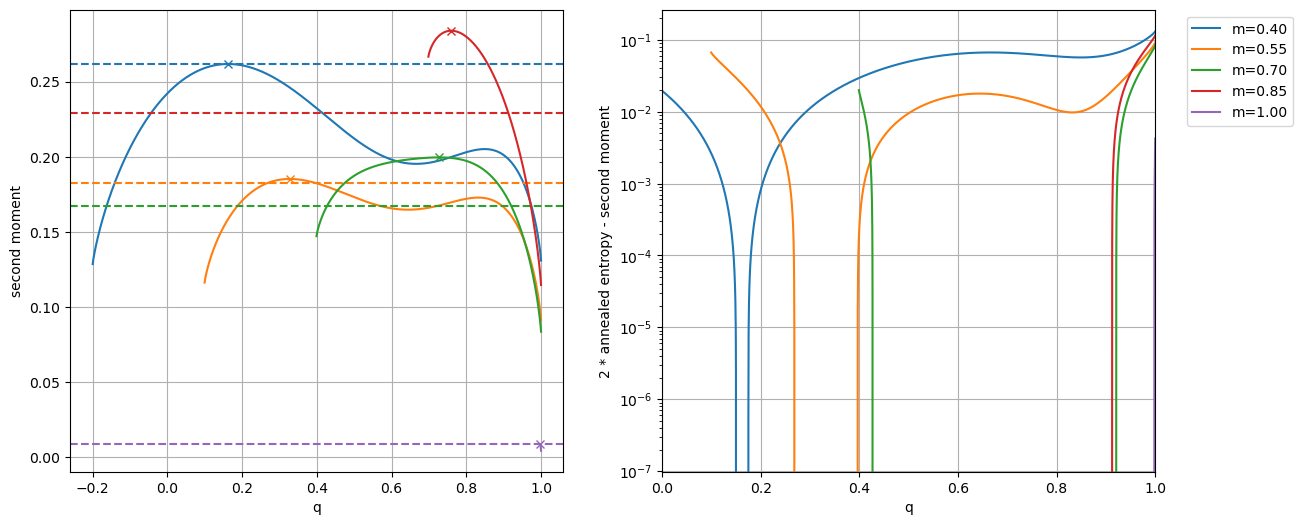

In [169]:
ms = np.linspace(0.4, 0.999, 5)

plt.figure(figsize=(14, 6))

for i, m in enumerate(ms):
    qs = np.linspace(2 * m - 1 + 1e-5, 1.0 - 1e-5, 5_000)

    sms = np.array([second_moment_bound(m, q, e, p) for q in qs])
    max_idx = np.argmax(sms)

    plt.subplot(1, 2, 1)
    plt.plot(qs, sms, color=f"C{i}", label=f"m={m:.2f}")
    plt.plot(qs[max_idx], sms[max_idx], "x", color=f"C{i}")
    plt.axhline(2 * annealed_entropy(m, e, p), color=f"C{i}", linestyle="--")

    plt.subplot(1, 2, 2)
    plt.plot(qs, (2 * annealed_entropy(m, e, p) - sms), label=f"m={m:.2f}", color=f"C{i}")
    plt.plot(qs[max_idx], (2 * annealed_entropy(m, e, p) - sms[max_idx]), "x", color=f"C{i}")

plt.subplot(1, 2, 1)
plt.xlabel("q")
plt.ylabel("second moment")
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel("q")
plt.ylabel("2 * annealed entropy - second moment")
plt.yscale("log")
# plt.xlim(np.min(ms)**2 - 0.1, np.max(ms)**2 + 0.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0.0, 1.0)
plt.grid()

In [178]:
file_path = f"./data/multiple_q_vs_m_e{e:.4f}_p{p:d}.pkl"
if os.path.exists(file_path):
    print("Data is already saved.")

    with open(file_path, "rb") as f:
        tmp = pickle.load(f)
        qs_maximal = tmp["qs_maximal"]
        ms = tmp["ms"]

    print("Data is loaded.")
else:
    print("Data is not saved.")

    ms = np.linspace(0.01, 0.999, 100)
    qs_maximal = np.nan * np.ones((len(ms), 4))
    n_points = 10_000_000

    for i, m in enumerate(ms):
        qs = np.linspace(2 * m - 1 + 1e-9, 1.0 - 1e-9, n_points)

        second_moment_potential = second_moment_bound(m, qs, e, p)

        peaks, _ = find_peaks(second_moment_potential)
        max_idx = np.argmax(second_moment_potential)

        if not max_idx in peaks:
            extremas = np.append(peaks, max_idx)
        else:
            extremas = peaks

        for j, idx in enumerate(extremas[:4]):
            qs_maximal[i, j] = qs[idx]

    data = {"ms": ms, "qs_maximal": qs_maximal}

    with open(file_path, "wb") as f:
        pickle.dump(data, f)

    print("Data is saved.")

Data is already saved.
Data is loaded.


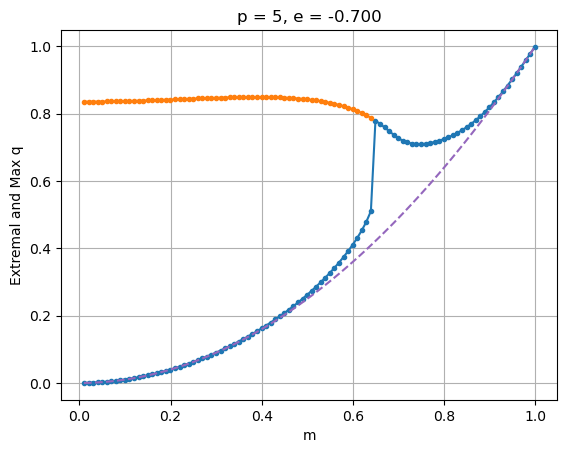

In [179]:
plt.plot(ms, qs_maximal, ".-")
plt.plot(ms, ms**2, "--", label="m^2")
plt.xlabel("m")
plt.ylabel("Extremal and Max q")
plt.title(f"p = {p}, e = {e:.3f}")
plt.grid()

In [157]:
p=5
n_points_m = 2_500
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
es = -1 / (2 * Teqs)
ms = np.linspace(0.0, 0.999, n_points_m)

qs = np.empty((len(es), len(ms)))
tol=1e-5
for j,e in tqdm(enumerate(es), total=len(es)):
    for i,m in enumerate(ms):
        bnds = [(2*m-1+tol, 1-tol)]
        max1 = minimize(lambda q: -second_moment_bound(m, q, e, p), x0 = 1-tol,method='SLSQP', bounds=bnds,tol=tol*1e-5)
        max2 = minimize(lambda q: -second_moment_bound(m, q, e, p), x0 = max(tol,2*m-1+tol),method='SLSQP', bounds=bnds,tol=tol*1e-5)
        if max1.fun < max2.fun:
            qs[j][i] = max1.x[0]
        else:
            qs[j][i] = max2.x[0]

  0%|          | 0/10 [00:00<?, ?it/s]

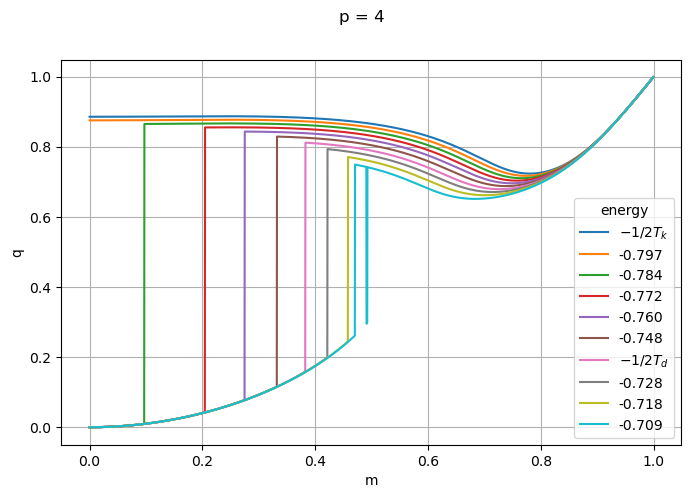

In [158]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle(f"p = {p}")

for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)
    ax.plot(ms, qs[i], label=legend_name)
ax.legend(title="energy")
ax.set_xlabel("m")
ax.set_ylabel("q")
ax.grid()
fig.savefig(f"./imgs/q_2nd_moment_p{p}.png", dpi=360)

### 1st vs 2nd Ratio

In [226]:
p=5
n_points_m = 1_000
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack(
    (
        np.linspace(T_kauz, T_dyn, n_points_T),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
es = -1 / (2 * Teqs)
ms = np.linspace(0.0, 0.999, n_points_m)

ratios = np.empty((len(es), len(ms)))
tol=1e-5
for j,e in tqdm(enumerate(es), total=len(es)):
    for i,m in enumerate(ms):
        bnds = [(2*m-1+tol, 1-tol)]
        max1 = minimize(lambda q: -second_moment_bound(m, q, e, p), x0 = 1-tol,method='SLSQP', bounds=bnds,tol=tol*1e-3)
        max2 = minimize(lambda q: -second_moment_bound(m, q, e, p), x0 = max(tol,2*m-1+tol),method='SLSQP', bounds=bnds,tol=tol*1e-3)
        if max1.fun < max2.fun:
            q = max1.x[0]
        else:
            q = max2.x[0]
        ratios[j][i] = 2*annealed_entropy(m, e, p)-second_moment_bound(m, q, e, p)
        #if ratios[j][i] > 1:
        #    print(f"p={p}, m={m}, e={e}, q={q}, annealed_entropy={annealed_entropy(m, e, p)}, second_moment={second_moment_bound(m, q, e, p)}")

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/ghio/Desktop/fixed-energy-slice/.conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


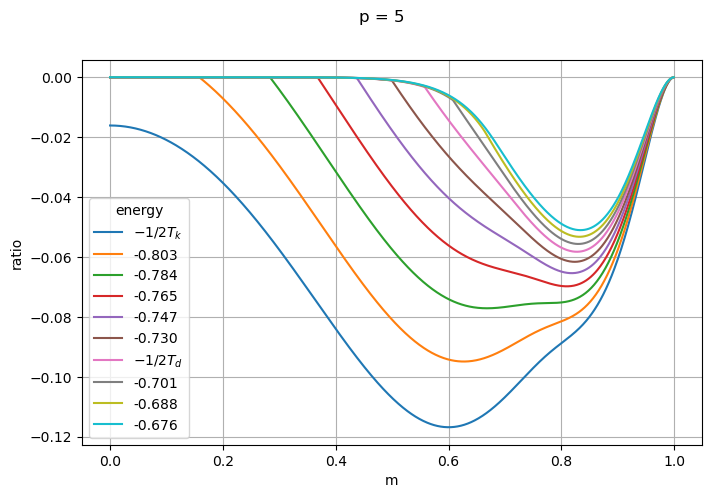

In [227]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle(f"p = {p}")

for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)
    ax.plot(ms, ratios[i], label=legend_name)
ax.legend(title="energy")
ax.set_xlabel("m")
ax.set_ylabel("ratio")
ax.grid()
#ax.set_ylim(0., 1.02)
fig.savefig(f"./imgs/ratio_2nd_moment_p{p}.png", dpi=360)

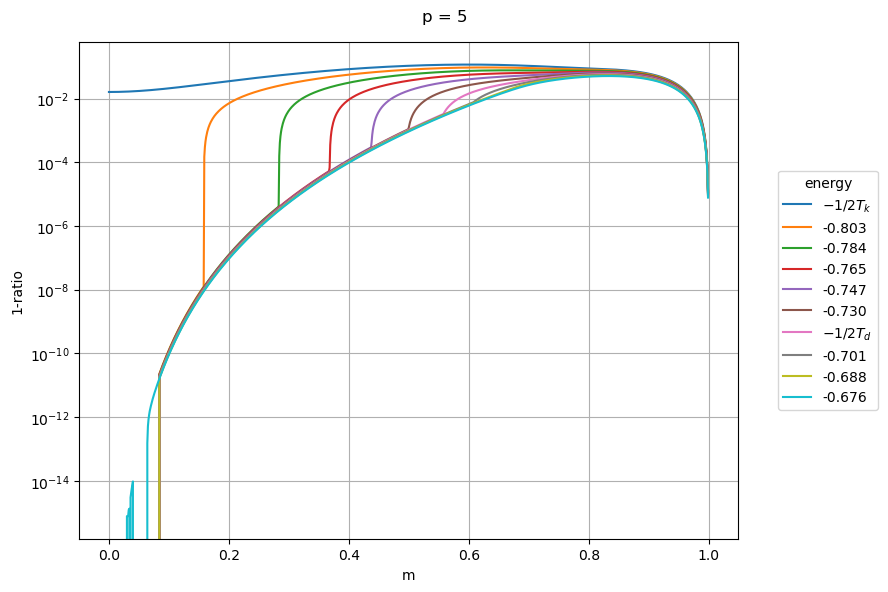

In [231]:
fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle(f"p = {p}")

for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)
    ax.plot(ms, - ratios[i], label=legend_name)
lgd = ax.legend(title="energy", loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_xlabel("m")
ax.set_ylabel("1-ratio")
ax.grid()
ax.set_yscale("log")
#ax.set_ylim(0., 1.02)
plt.tight_layout()
#fig.savefig(f"./imgs/1mratio_2nd_moment_p{p}.png", bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=360)